#### Import Data and Libraries

In this section I create 3 datasets: 
1. Complete Dataset with all data
2. Data of individuals who have a high Climate Change Risk Perception (q2 >= 6) 
2. Data of individuals who have Low Climate Change Risk Perception (q2 <= 5) 

With all datasets I will predict pro-environmental behaviour (qb5). 

In [14]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from matplotlib import pyplot
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight


df = pd.read_csv('df-climatechange.csv')
df = df.drop([ 'qb1a'], axis = 1)
df['qb5'] = df['qb5'].replace({'No': 0, 'Yes':1})

#pd.set_option('display.max_columns', None)
df1 = df[df.qb2 >= 6]
df2 = df[df.qb2 <= 5]


In [15]:
print(len(df1))
print(len(df2))

19072
2906


#### Assumptions
https://pythonfordatascienceorg.wordpress.com/logistic-regression-python/


1. Assumption of Continuous IVs being Linearly Related to the Log Odds

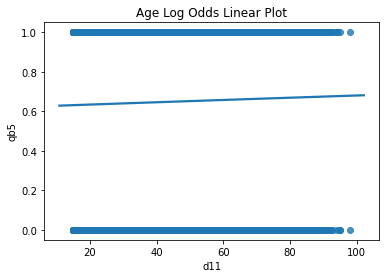

In [16]:
age = sns.regplot(x= 'd11', y= 'qb5', data= df, logistic= True, ci = None).set_title("Age Log Odds Linear Plot")
age.figure.savefig("logg odd age.png")

In this case there is not an "S" curve line

In [17]:
#qb2 = sns.regplot(x= 'qb2', y= 'qb5', data= df, logistic= True, ci = None).set_title("Risk Perception Log Odds Linear Plot")


 The current plot gives you an intuition how the logistic model fits an ‘S’ curve line and how the probability changes from 0 to 1 with observed values. 

2. Assumption of Lack of outliers

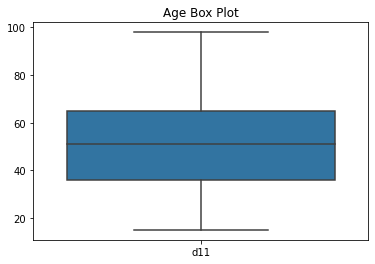

In [18]:
age_rank_box = sns.boxplot(data= df[['d11']]).set_title("Age Box Plot")
#age_rank_box.figure.savefig("outliers.png")

In [19]:
#rp_rank_box = sns.boxplot(data= df[['qb2']]).set_title("Risk Perception Box Plot")


There are some outliers in the risk perception variable. The outliers are not so far away from the rest of the values in their respective variable. Thus, the values can be kept and used in the analysis.

In [20]:
#functions and set parameters

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]



solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid

{'solver': ['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['l2'],
 'C': [100, 10, 1.0, 0.1, 0.01]}

### Complete Dataset

In this part there is the complete dataset. I will predict pro-environmental behaviour (qb5). The predictors are: climate change risk perception, clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 

In [21]:

cc_num = df[['qb5', 'qb2' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 111  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.43641457, 0.76697577])

In [22]:
#find optimal parameter 


# example of grid searching key hyperparametres for logistic regression

# define dataset
# define models and parameters
model = LogisticRegression(class_weight={0: 1.43631197 , 1:0.76700502})

logreg = RandomizedSearchCV(model,grid, n_jobs=-1, cv=3, random_state = seed)
logreg = logreg.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (logreg.best_score_, logreg.best_params_))
means = logreg.cv_results_['mean_test_score']
stds = logreg.cv_results_['std_test_score']
params = logreg.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    
    

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Best: 0.666797 using {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
0.666212 (0.002150) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
0.666537 (0.004185) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1.0}
0.664457 (0.004007) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}
0.666667 (0.001688) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}
0.664912 (0.004762) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 100}
0.664392 (0.004081) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 100}
0.664717 (0.003667) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}
0.666797 (0.002078) with: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
0.664392 (0.004081) with: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}
0.664457 (0.004007) with: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}


C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [23]:
print(logreg.best_params_)
print(logreg.best_estimator_)

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
LogisticRegression(C=0.1, class_weight={0: 1.43631197, 1: 0.76700502})


In [24]:
#fit model with optimal parameters  Threshold 0.5

print(classification_report(y_test, logreg.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.52      0.66      0.58      2296
           1       0.79      0.67      0.73      4298

    accuracy                           0.67      6594
   macro avg       0.65      0.67      0.65      6594
weighted avg       0.69      0.67      0.68      6594



(0.0, 1.0)

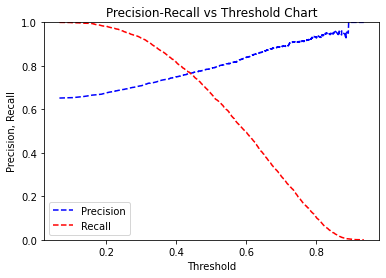

In [25]:
### Predict test_y values and probabilities based on fitted logistic  regression model
#uso modello normale

pred_y=logreg.best_estimator_.predict(X_test) 

probs_y=logreg.best_estimator_.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first  column of  array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


Best Threshold=0.519208, G-Mean=0.669


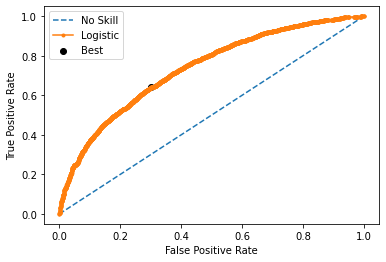

In [26]:
#ROC AUC

yhat = logreg.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


Text(0.5, 19.5, 'Predicted label')

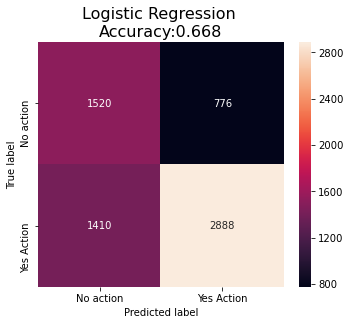

In [27]:
#confusion matrix

y_scores = logreg.best_estimator_.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test,logreg.best_estimator_.predict(X_test))
cm = pd.DataFrame(cm,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])


plt.figure(figsize=(5.5,4.5))
sns.heatmap(cm, annot=True, fmt="d")

plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, logreg.best_estimator_.predict(X_test)) ), fontdict= {'fontsize' : 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('Logistic Regression_confusionmatrix.png')

    

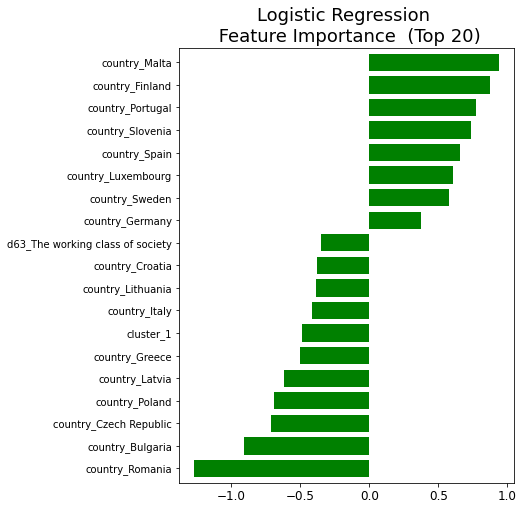

In [28]:
 
#checking the magnitude of coefficients
from pandas import Series, DataFrame
predictors = X_train.columns

coef = Series(logreg.best_estimator_.coef_.flatten(), predictors).sort_values()
sel = coef[np.abs(coef)>=0.335]

plt.figure(figsize = (6, 8))
 
sel.plot.barh(  width = 0.77, color = 'green')
plt.xticks(fontsize=12)

plt.title('Logistic Regression \n Feature Importance  (Top 20)',
          fontdict= {'fontsize' : 18})

plt.show()


In [29]:
odds = np.exp(logreg.best_estimator_.coef_[0])
odds_df = pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)


pd.set_option('display.max_rows', None)

odds_df.to_csv('odds_df.csv')

In [30]:
coefs = np.abs(logreg.best_estimator_.coef_[0])
indices = np.argsort(coefs)[::-1]
lg1 = pd.DataFrame({'variable' : X.columns[indices[:]], 'importance_lg' : logreg.best_estimator_.coef_[0]})    


lg1.to_csv('imp.csv', index=False, encoding='utf-8')


In [31]:

pd.set_option('display.max_rows', None)


lg1

,variable,importance_lg
0,country_Romania,0.172588
1,country_Malta,0.001655
2,country_Bulgaria,-0.110913
3,country_Finland,0.033848
4,country_Portugal,-0.119521
5,country_Slovenia,0.006813
6,country_Czech Republic,-0.063769
7,country_Poland,-0.129992
8,country_Spain,-0.305527
9,country_Latvia,-0.078007


### High Risk Perception


In this part there is data of individuals who have a high Climate Change Risk Perception (q2 >= 6).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes

In [185]:
cc_num = df1[['qb5' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 101 # so that the result is reproducible

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,  random_state = seed,stratify=y)


class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.56726931, 0.73424266])

In [186]:
#find optimal parameter 

model = LogisticRegression(class_weight={0: 1.56837406 , 1:0.73400044})

logreg = RandomizedSearchCV(model,grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0, random_state = seed)
logreg = logreg.fit(X_train, y_train)
    
print(logreg.best_params_)
print(logreg.best_estimator_)

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}
LogisticRegression(C=0.1, class_weight={0: 1.56837406, 1: 0.73400044})


C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [187]:
#fit model with optimal parameters  Threshold 0.5

print(classification_report(y_test, logreg.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.64      0.54      1825
           1       0.80      0.66      0.72      3897

    accuracy                           0.65      5722
   macro avg       0.63      0.65      0.63      5722
weighted avg       0.69      0.65      0.66      5722



(0.0, 1.0)

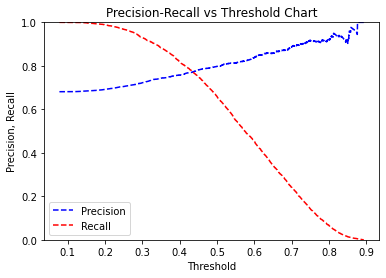

In [188]:
### Predict test_y values and probabilities based on fitted logistic  regression model
#uso modello normale

pred_y=logreg.best_estimator_.predict(X_test) 

probs_y=logreg.best_estimator_.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first  column of  array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


Best Threshold=0.493637, G-Mean=0.652


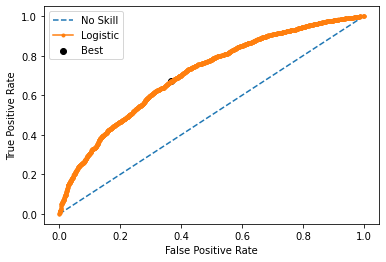

In [189]:
#roc
yhat = logreg.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()



Text(0.5, 19.5, 'Predicted label')

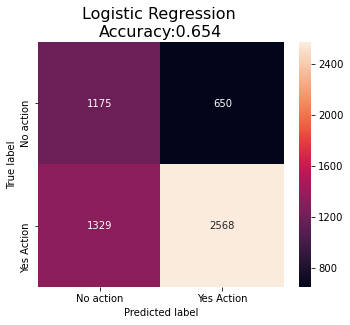

In [190]:
#confusion matrix 

    

y_scores = logreg.best_estimator_.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test,logreg.best_estimator_.predict(X_test))
cm = pd.DataFrame(cm,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])


plt.figure(figsize=(5.5,4.5))
sns.heatmap(cm, annot=True, fmt="d")

plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, logreg.best_estimator_.predict(X_test)) ), fontdict= {'fontsize' : 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')

    

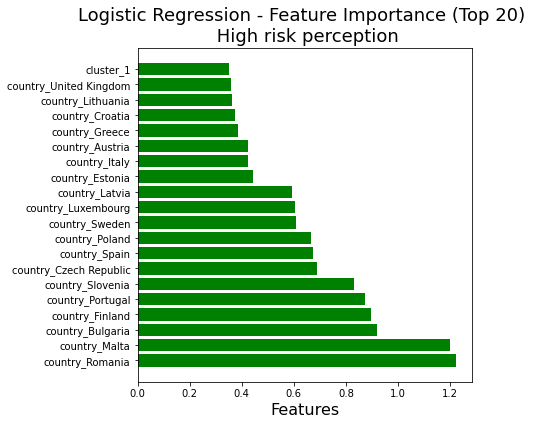

In [191]:
coefs = np.abs(logreg.best_estimator_.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure(figsize = (6, 8))
plt.barh(range(20), coefs[indices[:20]],
       color="g", align="center")
plt.yticks(range(20), X.columns[indices[:20]], rotation=0, ha='right')
plt.subplots_adjust(bottom=0.3)


#feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
plt.title('Logistic Regression - Feature Importance (Top 20) \n High risk perception', fontdict= {'fontsize' : 18})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

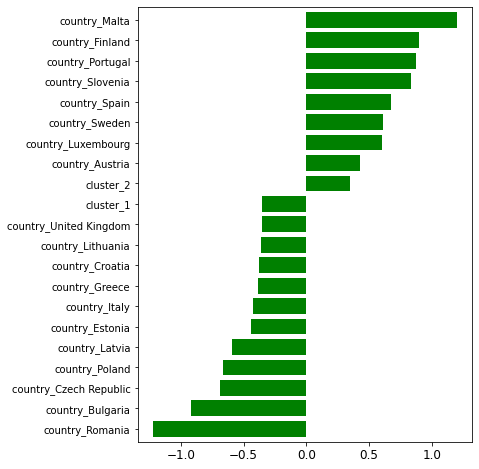

In [192]:
 
#checking the magnitude of coefficients
from pandas import Series, DataFrame
predictors = X_train.columns

coef = Series(logreg.best_estimator_.coef_.flatten(), predictors).sort_values()
sel = coef[np.abs(coef)>=0.345]

plt.figure(figsize = (6, 8))
 
sel.plot.barh(  width = 0.77, color = 'green')
plt.xticks(fontsize=12)

#plt.title('Logistic Regression \n Feature Importance  (Top 20) - High risk percpetion',
#          fontdict= {'fontsize' : 18})

plt.show()


In [193]:
odds = np.exp(logreg.best_estimator_.coef_[0])
odds_df = pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)



odds_df.to_csv('odds_df2.csv')


In [194]:
lg2 = pd.DataFrame({'variable' : X.columns[indices[:]], 'importance_lg' : logreg.best_estimator_.coef_[0]})    


lg2.to_csv('imp2.csv', index=False, encoding='utf-8')


In [43]:

pd.set_option('display.max_rows', None)


lg2

,variable,importance_lg
0,country_Romania,0.002008
1,country_Malta,-0.010549
2,country_Bulgaria,0.131567
3,country_Finland,-0.141899
4,country_Portugal,0.199826
5,country_Slovenia,-0.049147
6,country_Czech Republic,-0.133467
7,country_Spain,-0.119250
8,country_Poland,0.115581
9,country_Sweden,0.423384


### Low Risk Perception


In this part there is data of individuals who have a low Climate Change Risk Perception (q2 <= 5).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes

In [195]:
cc_num = df2[['qb5' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 101  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)


class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))


print(class_weights)



[0.92707384 1.08537887]


In [196]:
#find optimal parameter 

model = LogisticRegression(class_weight={0: 0.92119565  , 1:1.09354839})

logreg = RandomizedSearchCV(model,grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0)
logreg = logreg.fit(X_train, y_train)
    
print(logreg.best_params_)
print(logreg.best_estimator_)


{'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}
LogisticRegression(C=10, class_weight={0: 0.92119565, 1: 1.09354839},
                   solver='newton-cg')


C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [197]:
print(classification_report(y_test, logreg.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.63      0.65       470
           1       0.59      0.62      0.61       402

    accuracy                           0.63       872
   macro avg       0.63      0.63      0.63       872
weighted avg       0.63      0.63      0.63       872



(0.0, 1.0)

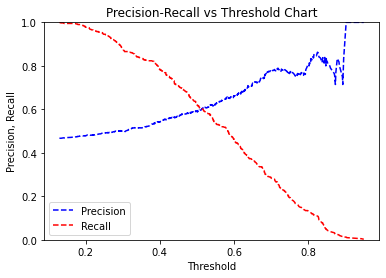

In [198]:
### Predict test_y values and probabilities based on fitted logistic  regression model

# predict probabilities

pred_y=logreg.best_estimator_.predict(X_test) 

probs_y=logreg.best_estimator_.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first  column of  array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


Best Threshold=0.536455, G-Mean=0.634


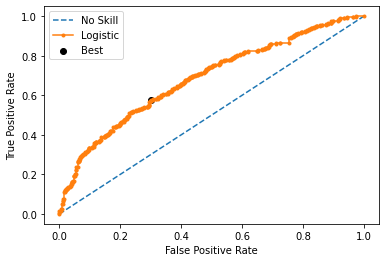

In [199]:
# predict probabilities
yhat = logreg.best_estimator_.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


Text(0.5, 19.5, 'Predicted label')

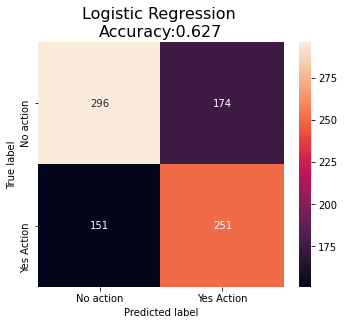

In [200]:
#confusion matrix 
cm = confusion_matrix(y_test,logreg.best_estimator_.predict(X_test))
cm = pd.DataFrame(cm,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])

plt.figure(figsize=(5.5,4.5))

sns.heatmap(cm, annot=True, fmt="d")
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, logreg.best_estimator_.predict(X_test)) ), fontdict= {'fontsize' : 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


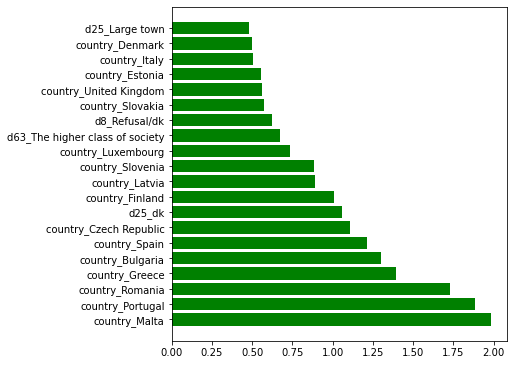

In [201]:
coefs = np.abs(logreg.best_estimator_.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure(figsize = (6, 8))
plt.barh(range(20), coefs[indices[:20]],
       color="g", align="center")
plt.yticks(range(20), X.columns[indices[:20]], rotation=0, ha='right')
plt.subplots_adjust(bottom=0.3)


#feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
#plt.title('Logistic Regression Feature Importance (Top 20) - Low risk perception', fontdict= {'fontsize' : 20})
plt.show()

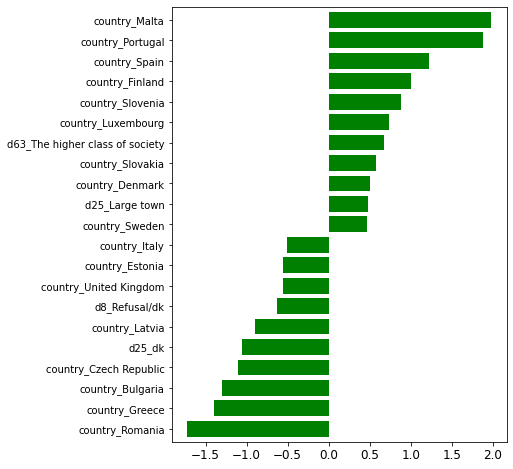

In [202]:
predictors = X_train.columns

coef = Series(logreg.best_estimator_.coef_.flatten(), predictors).sort_values()
sel = coef[np.abs(coef)>=0.46]

plt.figure(figsize = (6, 8))
 
sel.plot.barh(  width = 0.77, color = 'green')
plt.xticks(fontsize=12)

#plt.title('Logistic Regression \n Feature Importance  (Top 20) - low risk percpetion',
#          fontdict= {'fontsize' : 18})

plt.show()

In [203]:
odds = np.exp(logreg.best_estimator_.coef_[0])
odds_df = pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)


pd.set_option('display.max_rows', None)
odds_df
odds_df.to_csv('odds_df3.csv')

In [204]:
lg3 = pd.DataFrame({'variable' : X.columns[indices[:]], 'importance_lg' : logreg.best_estimator_.coef_[0]})    


lg3.to_csv('imp3.csv', index=False, encoding='utf-8')


#### REFERENCES 

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

https://stackoverflow.com/questions/65491584/regularized-l1-logistic-regression-feature-selection-returns-different-coef-whe


In [50]:
imp = pd.read_csv('imp3.csv')
imp

,variable,importance_lg,importance_dt,importance_rf,importance_gb,odds
0,cca_1,"0,017753","0,000000","0,006200","0,007691",1.006476
1,cca_2,"0,167401","0,000000","0,011028","0,015933",1.129289
2,cca_3,"0,398833","0,000000","0,006102","0,006277",1.017911
3,cca_4,"-0,405617","0,000000","0,005584","0,012052",1.027453
4,cca_5,"-0,561250","0,000000","0,007494","0,014207",0.841240
5,cluster_1,"-0,256186","0,426276","0,107565","0,057859",0.671103
6,cluster_2,"0,735099","0,000000","0,062236","0,000000",1.490084
7,country_Austria,"-0,398833","0,000000","0,017888","0,000000",0.979002
8,country_Belgium,"0,080522","0,000000","0,007876","0,000000",1.023511
9,country_Bulgaria,"0,052831","0,000000","0,009870","0,021334",0.272859


In [42]:
imp = pd.read_csv('imp.csv', sep = ';')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

odds = pd.read_csv('odds_df.csv')
odds  = odds.sort_values('Unnamed: 0', ascending=True).reset_index(drop=True)



final = pd.merge(imp, odds, left_index=True, right_index=True)

#pd.set_option('display.max_rows', None)

final.rename(columns={ final.columns[6]: "odds" }, inplace = True)
final = final.drop('Unnamed: 0', axis = 1)


final.to_csv('imp.csv', index=False, encoding='utf-8')




In [45]:
imp = pd.read_csv('imp2.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

odds = pd.read_csv('odds_df2.csv')
odds  = odds.sort_values('Unnamed: 0', ascending=True).reset_index(drop=True)



final = pd.merge(imp, odds, left_index=True, right_index=True)

#pd.set_option('display.max_rows', None)

final.rename(columns={ final.columns[6]: "odds" }, inplace = True)
final = final.drop('Unnamed: 0', axis = 1)


final.to_csv('imp2.csv', index=False, encoding='utf-8')


In [46]:
imp = pd.read_csv('imp3.csv', sep = ';')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

odds = pd.read_csv('odds_df3.csv')
odds  = odds.sort_values('Unnamed: 0', ascending=True).reset_index(drop=True)



final = pd.merge(imp, odds, left_index=True, right_index=True)

#pd.set_option('display.max_rows', None)

final.rename(columns={ final.columns[6]: "odds" }, inplace = True)
final = final.drop('Unnamed: 0', axis = 1)


final.to_csv('imp3.csv', index=False, encoding='utf-8')